In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [27]:
#load data
train_df = pd.read_csv("train_split_merged_expanded_data.csv")
val_df = pd.read_csv("val_split_merged_expanded_data.csv")
test_df = pd.read_csv("test_split_merged_expanded_data.csv")

In [28]:
#datetime
train_df['date'] = pd.to_datetime(train_df['date'])
val_df['date'] = pd.to_datetime(val_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

for df in [train_df, val_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df.drop('date', axis=1, inplace=True)

for df in [train_df, val_df, test_df]:
    df = pd.get_dummies(df, columns=['weekday'], prefix='wd')

all_columns = set(train_df.columns) | set(val_df.columns) | set(test_df.columns)

for df in [train_df, val_df, test_df]:
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0

train_df = train_df[sorted(train_df.columns)]
val_df   = val_df[sorted(val_df.columns)]
test_df  = test_df[sorted(test_df.columns)]

In [29]:
#prepare data
X_train = train_df.drop(columns=['umsatz'])
y_train = train_df['umsatz']
X_val = val_df.drop(columns=['umsatz'])
y_val = val_df['umsatz']
X_test = test_df.drop(columns=['umsatz'])
y_test = test_df['umsatz']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [30]:
#define model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\lonep\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
#train model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val))

Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 65403.1484 - mae: 208.7927 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65392.5664 - mae: 208.7669 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65392.5547 - mae: 208.7668 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65392.5625 - mae: 208.7669 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 65392.5508 - mae: 208.7669 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65392.5664 - mae: 208.7670 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65392.5586 - mae: 208.7669 - val_loss: 55053.4531 - val_mae: 195.2793
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 65392.5664 - mae: 208.

In [32]:
#evaluate model
val_loss, val_mae = model.evaluate(X_val_scaled, y_val)
print(f'Validation MAE: {val_mae}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55053.4531 - mae: 195.2793
Validation MAE: 195.27928161621094


In [33]:
#save model
model.save('trained_model_regression.h5')

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 55053.451, MAE: 195.279, R2: -2.254


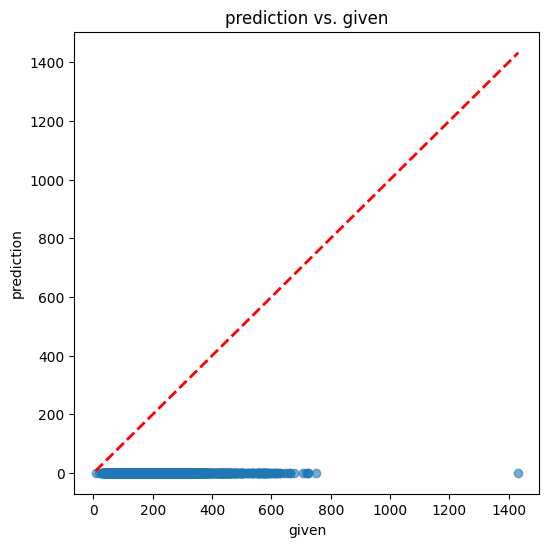

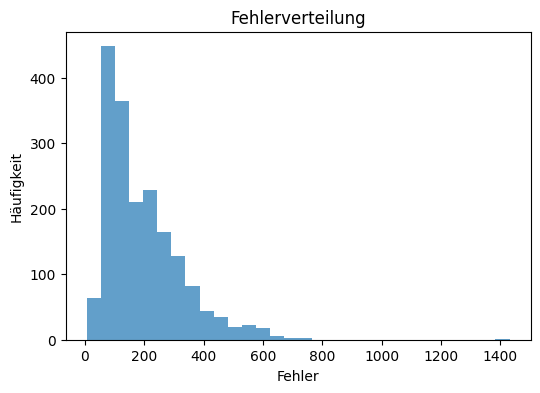

In [34]:
#visualize training history
#predictions
predictions = model.predict(X_val_scaled).flatten()
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

#scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val, predictions, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--', lw=2)
plt.xlabel("given")
plt.ylabel("prediction")
plt.title("prediction vs. given")
plt.show()

# Fehlerverteilung
errors = y_val.values - predictions
plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel("Fehler")
plt.ylabel("Häufigkeit")
plt.title("Fehlerverteilung")
plt.show()
